In [192]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
from glob import glob
from PIL import Image
import os
import cv2
import scipy.ndimage as ndimage
from skimage import io


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_curve,auc



In [171]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.losses import binary_crossentropy
from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import backend as K
from keras import activations
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims




In [3]:
imagepatches = glob('images/**/*.png', recursive=True)
len(imagepatches) # number of images

277524

In [4]:
imagepath=pd.DataFrame(imagepatches,columns=['path']) # taking path of the images in the dataframe
imagepath.head()

,path
0,images/9036/0/9036_idx5_x1051_y2401_class0.png
1,images/9036/0/9036_idx5_x2951_y951_class0.png
2,images/9036/0/9036_idx5_x3001_y1451_class0.png
3,images/9036/0/9036_idx5_x3051_y801_class0.png
4,images/9036/0/9036_idx5_x951_y1901_class0.png


In [5]:
file_split = imagepath['path'].str.split('_')


In [6]:
file_split

0         [images/9036/0/9036, idx5, x1051, y2401, class...
1         [images/9036/0/9036, idx5, x2951, y951, class0...
2         [images/9036/0/9036, idx5, x3001, y1451, class...
3         [images/9036/0/9036, idx5, x3051, y801, class0...
4         [images/9036/0/9036, idx5, x951, y1901, class0...
                                ...                        
277519    [images/8957/1/8957, idx5, x1951, y701, class1...
277520    [images/8957/1/8957, idx5, x2051, y551, class1...
277521    [images/8957/1/8957, idx5, x1951, y651, class1...
277522    [images/8957/1/8957, idx5, x1451, y551, class1...
277523    [images/8957/1/8957, idx5, x1601, y501, class1...
Name: path, Length: 277524, dtype: object

In [7]:
#Getting patient id, class, x and  y coordinates in a dataframe
imagepath['patientid'] = [x[0] for x in file_split]
imagepath['x'] = [x[2] for x in file_split]
imagepath['y'] = [x[-2] for x in file_split]
imagepath['Class_png']=[x[-1] for x in file_split]

In [8]:
fs = imagepath['patientid'].str.split('/')
imagepath['P_id']=[x[-1] for x in fs]

In [9]:
imagepath['X'] = imagepath['x'].str.extract('(\d+)', expand=False)
imagepath['Y'] = imagepath['y'].str.extract('(\d+)', expand=False)
imagepath['Class'] = imagepath['Class_png'].str.extract('(\d+)', expand=False)
imagepath=imagepath.drop(['Class_png'],axis=1)
imagepath=imagepath.drop(['x'],axis=1)
imagepath=imagepath.drop(['y'],axis=1)
imagepath=imagepath.drop(['patientid'],axis=1)

In [10]:
imagepath.shape

(277524, 5)

In [16]:

imagepath.head()

,path,P_id,X,Y,Class
0,images/9036/0/9036_idx5_x1051_y2401_class0.png,9036,1051,2401,0
1,images/9036/0/9036_idx5_x2951_y951_class0.png,9036,2951,951,0
2,images/9036/0/9036_idx5_x3001_y1451_class0.png,9036,3001,1451,0
3,images/9036/0/9036_idx5_x3051_y801_class0.png,9036,3051,801,0
4,images/9036/0/9036_idx5_x951_y1901_class0.png,9036,951,1901,0


In [17]:
imagepath.Class.value_counts()

0    198738
1     78786
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

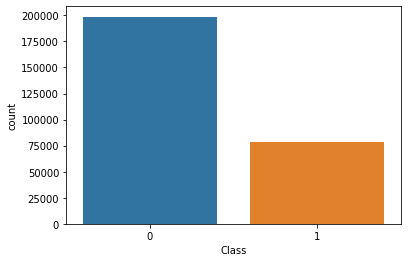

In [18]:
sns.countplot(x="Class",data=imagepath)

In [22]:
imagepath['Class']=imagepath.Class.astype(np.int)
imagepath['X']=imagepath.X.astype(np.int)
imagepath['Y']=imagepath.Y.astype(np.int)
imagepath['P_id']=imagepath.P_id.astype(np.int)

In [23]:
imagepath.dtypes

path     object
P_id      int64
X         int64
Y         int64
Class     int64
dtype: object

In [50]:
patients=imagepath_imb.P_id.unique()

In [51]:
len(patients) #Number of patients

279

In [55]:
#train test split according to patients
train_patients,testpatients=train_test_split(patients,test_size=0.3)
test_patients,val_patients=train_test_split(testpatients,test_size=0.5)

print(len(train_patients),len(val_patients),len(test_patients))

195 42 42


In [59]:
train_patients.dtype

dtype('int64')

In [64]:
#dataframes for training, validation, test patients id
train_df=imagepath[imagepath.P_id.isin(train_patients)]
val_df=imagepath[imagepath.P_id.isin(val_patients)]
test_df=imagepath[imagepath.P_id.isin(test_patients)]

In [65]:
train_df.Class.value_counts(),val_df.Class.value_counts(),test_df.Class.value_counts()

(0    136550
 1     50999
 Name: Class, dtype: int64,
 0    33757
 1    13540
 Name: Class, dtype: int64,
 0    28431
 1    14247
 Name: Class, dtype: int64)

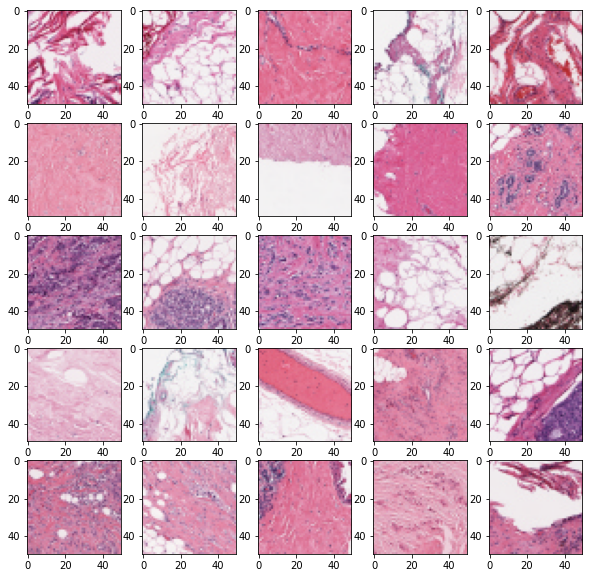

In [37]:
#Glimpse of images
plt.figure(figsize= (10,10))
#plt.suptitle("Benign tumor")

imgs = np.random.randint(0, len(imagepath.path), 25)
i=0
for loc in imgs:
    plt.subplot(5,5,i+1)
    img = load_img(imagepath.path[loc], target_size=(50,50))
    img = img_to_array(img)
    plt.imshow(img.astype("uint8"))
    i+=1

In [66]:
def load_data(files):
    X = []
    y = []
    for file in files:
        img = load_img(file, target_size = (50,50))
        pix = img_to_array(img)
        pix /= 255
        X.append(pix)
        if(file[-5] == '1'):
             y.append(1)
        elif(file[-5] == '0'):
            y.append(0)
    return np.stack(X), y

In [67]:
X,y=load_data(train_df.path) #Loading training images into numpy arrays
y=np.vstack(y)
X.shape,y.shape

((187549, 50, 50, 3), (187549, 1))

In [68]:
X_val,y_val=load_data(val_df.path) #Loading validation images into numpy arrays
y_val=np.vstack(y_val)
X_val.shape,y_val.shape

((47297, 50, 50, 3), (47297, 1))

## Training the model with imbalance data

In [90]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])



In [91]:
checkpoint = ModelCheckpoint("final_imbalance_best1.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')

In [85]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [92]:
M=model.fit(X, y,validation_data=(X_val, y_val),  epochs=100,callbacks=[checkpoint,es])

Train on 187549 samples, validate on 47297 samples
Epoch 1/100
187549/187549 [==============================] - 1232s 7ms/step - loss: 0.3464 - acc: 0.8559 - val_loss: 0.6287 - val_acc: 0.7451

Epoch 00001: val_acc improved from -inf to 0.74508, saving model to final_imbalance_best1.hdf5
Epoch 2/100
187549/187549 [==============================] - 1165s 6ms/step - loss: 0.3096 - acc: 0.8715 - val_loss: 0.4685 - val_acc: 0.8223

Epoch 00002: val_acc improved from 0.74508 to 0.82231, saving model to final_imbalance_best1.hdf5
Epoch 3/100
187549/187549 [==============================] - 1169s 6ms/step - loss: 0.2946 - acc: 0.8772 - val_loss: 0.3201 - val_acc: 0.8686

Epoch 00003: val_acc improved from 0.82231 to 0.86858, saving model to final_imbalance_best1.hdf5
Epoch 4/100
187549/187549 [==============================] - 1168s 6ms/step - loss: 0.2841 - acc: 0.8813 - val_loss: 0.4027 - val_acc: 0.8560

Epoch 00004: val_acc did not improve from 0.86858
Epoch 5/100
187549/187549 [=========

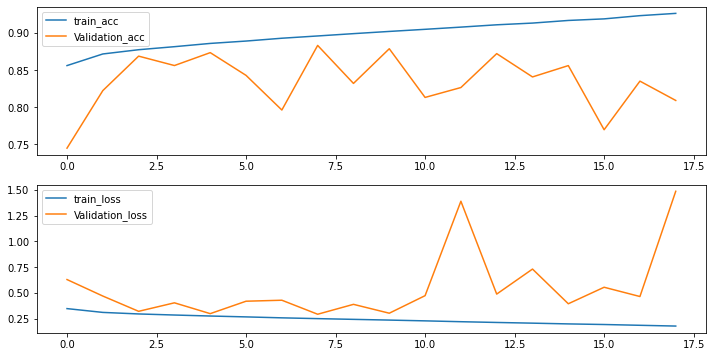

In [93]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(M.history['acc'], label="train_acc")
plt.plot(M.history['val_acc'], label = "Validation_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(M.history['loss'], label = "train_loss")
plt.plot(M.history['val_loss'], label = "Validation_loss")
plt.legend()

In [146]:
from tensorflow import keras
from keras import optimizers

In [149]:
opt=optimizers.SGD(lr=1e-3, momentum=0.9)

In [150]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['acc'])

checkpoint = ModelCheckpoint("final_imbalance_best5.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)



In [151]:
M=model.fit(X, y,validation_data=(X_val, y_val),  epochs=100,batch_size=256, callbacks=[checkpoint,es])

Train on 187549 samples, validate on 47297 samples
Epoch 1/100
187549/187549 [==============================] - 1019s 5ms/step - loss: 0.3659 - acc: 0.8430 - val_loss: 0.3523 - val_acc: 0.8479

Epoch 00001: val_acc improved from -inf to 0.84790, saving model to final_imbalance_best5.hdf5
Epoch 2/100
187549/187549 [==============================] - 1004s 5ms/step - loss: 0.3301 - acc: 0.8586 - val_loss: 0.4254 - val_acc: 0.8345

Epoch 00002: val_acc did not improve from 0.84790
Epoch 3/100
187549/187549 [==============================] - 1008s 5ms/step - loss: 0.3190 - acc: 0.8633 - val_loss: 0.3232 - val_acc: 0.8613

Epoch 00003: val_acc improved from 0.84790 to 0.86126, saving model to final_imbalance_best5.hdf5
Epoch 4/100
187549/187549 [==============================] - 1020s 5ms/step - loss: 0.3102 - acc: 0.8672 - val_loss: 0.5533 - val_acc: 0.8143

Epoch 00004: val_acc did not improve from 0.86126
Epoch 5/100
187549/187549 [==============================] - 982s 5ms/step - loss: 0

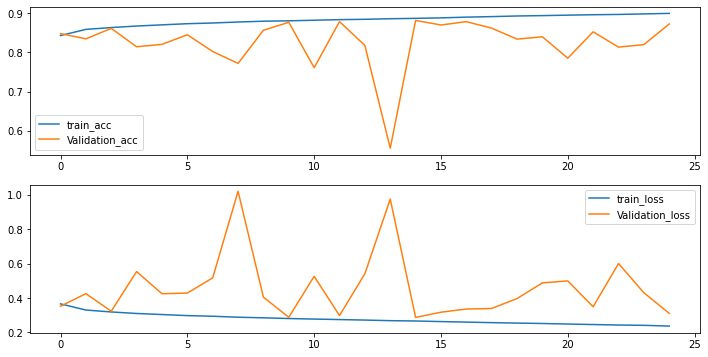

In [152]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(M.history['acc'], label="train_acc")
plt.plot(M.history['val_acc'], label = "Validation_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(M.history['loss'], label = "train_loss")
plt.plot(M.history['val_loss'], label = "Validation_loss")
plt.legend()

In [153]:
X_test,y_test=load_data(test_df.path)
y_test=np.vstack(y_test)
X_test.shape,y_test.shape

((42678, 50, 50, 3), (42678, 1))

In [216]:
model=load_model("final_imbalance_best1.hdf5")

In [217]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)


Test accuracy: 0.8390739959698205

Test Loss: 0.4034269063003046


In [218]:
Y_pred = model.predict(X_test)


In [219]:
y_pred = (Y_pred > 0.5).astype(np.int)
confusion_matrix(y_test, y_pred)

array([[25109,  3322],
       [ 3546, 10701]])

Text(0.5, 1.0, 'Cancer Prediction')

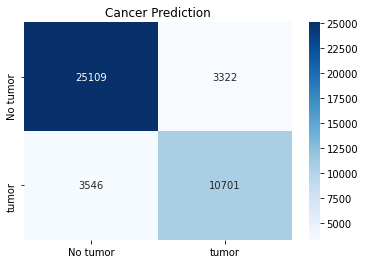

In [220]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,fmt="d",
                   xticklabels=['No tumor', 'tumor'],
                   yticklabels=['No tumor', 'tumor']).set_title('Cancer Prediction')

In [221]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:" ,precision)
print("Recall:", recall)



Precision: 0.8196777179371034
Recall: 0.8171306031050383


## Data Augmentation

In [159]:

def load_aug_data(files):
    X = []
    y = []
    datagen = ImageDataGenerator(horizontal_flip=True)

    for file in files:
        if(file[-5] == '1'):
            img = load_img(file, target_size = (50,50))
            data = img_to_array(img)
            pix =data/ 255
            X.append(pix)
            y.append(1)
            samples=expand_dims(data,0)
            it = datagen.flow(samples, batch_size=1) 
            batch=it.next()
            X.append(np.squeeze(batch, axis=0))
            y.append(1)

        elif(file[-5] == '0'):
            img = load_img(file, target_size = (50,50))
            pix = img_to_array(img)
            pix /= 255
            X.append(pix)
            y.append(0)
    return np.stack(X), y

In [162]:
X_aug,y_aug=load_aug_data(train_df.path)
y_aug=np.vstack(y_aug)
X_aug.shape,y_aug.shape

((238548, 50, 50, 3), (238548, 1))

In [163]:
np.count_nonzero(y_aug == 1),np.count_nonzero(y_aug == 0)

(101998, 136550)

In [164]:
model_aug = Sequential()
model_aug.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(50, 50, 3)))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model_aug.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(BatchNormalization())


model_aug.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(BatchNormalization())


model_aug.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Flatten())
#model_aug.add(Dense(256, activation='relu'))
model_aug.add(Dense(128, activation = 'relu'))
model_aug.add(Dropout(0.4))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [165]:
checkpoint_aug = ModelCheckpoint("final_aug_best.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')

In [166]:
es_aug = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [167]:
M_aug=model_aug.fit(X_aug, y_aug,validation_data=(X_val, y_val),batch_size=256,  epochs=100,callbacks=[checkpoint_aug,es_aug])


Train on 238548 samples, validate on 47297 samples
Epoch 1/100
238548/238548 [==============================] - 1265s 5ms/step - loss: 0.3478 - acc: 0.8457 - val_loss: 0.7413 - val_acc: 0.4030

Epoch 00001: val_acc improved from -inf to 0.40305, saving model to final_aug_best.hdf5
Epoch 2/100
238548/238548 [==============================] - 1221s 5ms/step - loss: 0.2882 - acc: 0.8772 - val_loss: 0.4568 - val_acc: 0.8155

Epoch 00002: val_acc improved from 0.40305 to 0.81551, saving model to final_aug_best.hdf5
Epoch 3/100
238548/238548 [==============================] - 1201s 5ms/step - loss: 0.2711 - acc: 0.8850 - val_loss: 1.5512 - val_acc: 0.7103

Epoch 00003: val_acc did not improve from 0.81551
Epoch 4/100
238548/238548 [==============================] - 1193s 5ms/step - loss: 0.2716 - acc: 0.8851 - val_loss: 0.4267 - val_acc: 0.8314

Epoch 00004: val_acc improved from 0.81551 to 0.83141, saving model to final_aug_best.hdf5
Epoch 5/100
238548/238548 [==============================

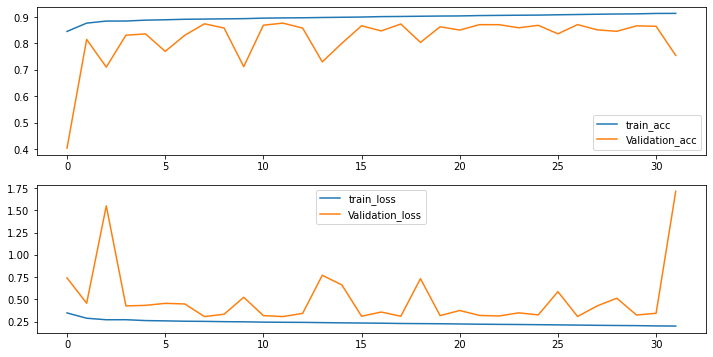

In [168]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(M_aug.history['acc'], label="train_acc")
plt.plot(M_aug.history['val_acc'], label = "Validation_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(M_aug.history['loss'], label = "train_loss")
plt.plot(M_aug.history['val_loss'], label = "Validation_loss")
plt.legend()

In [172]:
model=load_model("final_aug_best.hdf5")

In [173]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)


Test accuracy: 0.8487276817095459

Test Loss: 0.34988978740778093


In [174]:
Y_pred = model.predict(X_test)

In [175]:
y_pred = (Y_pred > 0.5).astype(np.int)
confusion_matrix(y_test, y_pred)

array([[24690,  3741],
       [ 2715, 11532]])

Text(0.5, 1.0, 'Cancer Prediction')

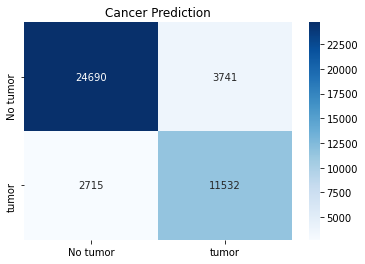

In [176]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,fmt="d",
                   xticklabels=['No tumor', 'tumor'],
                   yticklabels=['No tumor', 'tumor']).set_title('Cancer Prediction')

In [178]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:" ,precision)
print("Recall:", recall)

Precision: 0.827994216265608
Recall: 0.8389259203933639


In [180]:
model_aug = Sequential()
model_aug.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(50, 50, 3)))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(BatchNormalization())

model_aug.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(BatchNormalization())


model_aug.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(BatchNormalization())


model_aug.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Flatten())

model_aug.add(Dense(128, activation = 'relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['acc'])

checkpoint_aug = ModelCheckpoint("final_aug_best5.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')
es_aug = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)



In [181]:
M_aug=model_aug.fit(X_aug, y_aug,validation_data=(X_val, y_val),batch_size=256,  epochs=100,callbacks=[checkpoint_aug,es_aug])

Train on 238548 samples, validate on 47297 samples
Epoch 1/100
238548/238548 [==============================] - 1462s 6ms/step - loss: 0.3618 - acc: 0.8373 - val_loss: 0.4538 - val_acc: 0.7766

Epoch 00001: val_acc improved from -inf to 0.77658, saving model to final_aug_best5.hdf5
Epoch 2/100
238548/238548 [==============================] - 1495s 6ms/step - loss: 0.2907 - acc: 0.8766 - val_loss: 0.3607 - val_acc: 0.8433

Epoch 00002: val_acc improved from 0.77658 to 0.84329, saving model to final_aug_best5.hdf5
Epoch 3/100
238548/238548 [==============================] - 1563s 7ms/step - loss: 0.2767 - acc: 0.8831 - val_loss: 0.4192 - val_acc: 0.8299

Epoch 00003: val_acc did not improve from 0.84329
Epoch 4/100
238548/238548 [==============================] - 1616s 7ms/step - loss: 0.2699 - acc: 0.8847 - val_loss: 0.3493 - val_acc: 0.8528

Epoch 00004: val_acc improved from 0.84329 to 0.85276, saving model to final_aug_best5.hdf5
Epoch 5/100
238548/238548 [===========================

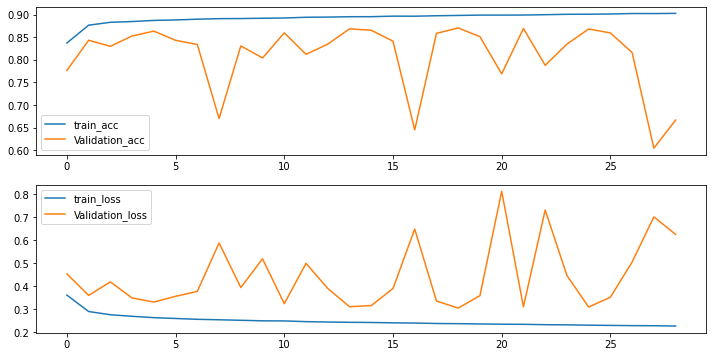

In [182]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(M_aug.history['acc'], label="train_acc")
plt.plot(M_aug.history['val_acc'], label = "Validation_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(M_aug.history['loss'], label = "train_loss")
plt.plot(M_aug.history['val_loss'], label = "Validation_loss")
plt.legend()

In [198]:
def original_breast_tissue(patient_id):
    patient_df = test_df.loc[test_df['P_id']== patient_id,:]
    
    max_coord = np.max((*patient_df.X,*patient_df.Y))
    base = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    
    for X,Y,Class,path in zip(patient_df['X'],patient_df['Y'],patient_df['Class'],patient_df['path']):
        try:
            img = io.imread(path)
            base[Y:Y+50,X:X+50] = img
            
            if Class == 1:
                mask[Y:Y+50,X:X+50] = [0,0,255]
        except: pass
    alpha = 0.6
    img = (mask * (1.0 - alpha) + base * alpha).astype('uint8')
    io.imshow(img)
    return img

In [213]:
def predicted_breast_tissue(patient_id):
    patient_df = prediction_df.loc[test_df['P_id']== patient_id,:]
    
    max_coord = np.max((*patient_df.X,*patient_df.Y))
    base = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    
    for X,Y,Class,path in zip(patient_df['X'],patient_df['Y'],patient_df['Class'],patient_df['path']):
        try:
            img = io.imread(path)
            base[Y:Y+50,X:X+50] = img
            
            if Class == 1:
                mask[Y:Y+50,X:X+50] = [0,0,255]
        except: pass
    alpha = 0.6
    img = (mask * (1.0 - alpha) + base * alpha).astype('uint8')
    io.imshow(img)
    return img

In [189]:
prediction_df=test_df.filter(['P_id','X','Y','path'],axis=1)
prediction_df['Class']=y_pred
#print("Original data:",data.target.value_counts())
print("Predicted data:",prediction_df.Class.value_counts())

Predicted data: 0    27405
1    15273
Name: Class, dtype: int64


In [190]:
prediction_df.P_id.value_counts()

10290    2031
12880    1935
10302    1907
14155    1877
13462    1754
12906    1703
9265     1677
12818    1611
9290     1542
8918     1541
13613    1457
9178     1443
12821    1385
9036     1306
9345     1185
9266     1171
15902    1167
9325     1128
16896    1127
12820    1122
12955    1062
15510    1061
9176     1045
15903    1039
10276     939
16570     917
10274     878
15513     869
12901     808
12822     761
15514     638
14306     431
16533     367
10255     272
12811     251
16531     249
9035      236
14078     221
12871     182
8916      171
9175      118
9262       94
Name: P_id, dtype: int64

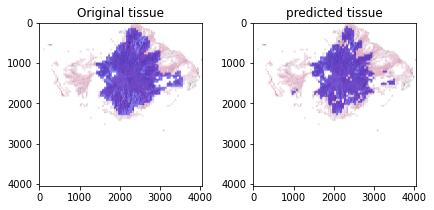

In [214]:
fig, axes = plt.subplots(1, 2)
img1 = original_breast_tissue(12818)
img2 = predicted_breast_tissue(12818)
axes[0].imshow(img1)
axes[1].imshow(img2) 
axes[0].title.set_text('Original tissue')
axes[1].title.set_text('predicted tissue')
#This has more false negatives

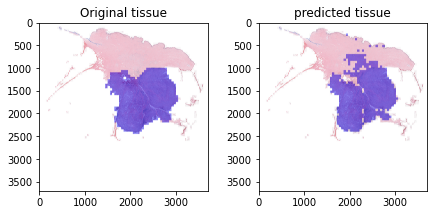

In [215]:
fig, axes = plt.subplots(1, 2)
img1 = original_breast_tissue(13613)
img2 = predicted_breast_tissue(13613)
axes[0].imshow(img1)
axes[1].imshow(img2) 
axes[0].title.set_text('Original tissue')
axes[1].title.set_text('predicted tissue')

#With false negatives and false positives